# Análisis del Dataset Zoo - Clasificación Multiclase

Este notebook implementa y evalúa 6 algoritmos de clasificación en el dataset Zoo de UCI:
1. Naive Bayes Gaussiano
2. MLE Multivariante (Full Bayesian Gaussian)
3. Histogram Bayes
4. Parzen Windows
5. k-NN Density Bayes
6. k-NN Rule

Dataset: 17 atributos (15 binarios + 1 numérico + 1 clase), 7 clases de animales

## 1. Importación de librerías

In [39]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from scipy.stats import multivariate_normal
from sklearn.model_selection import cross_val_score

# Silenciar warnings
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
warnings.filterwarnings('ignore', category=UserWarning, module='joblib')

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Carga y análisis exploratorio del dataset

In [40]:
# Clases del Zoo dataset (1-7 -> labels para report)
class_names = ['mammal', 'bird', 'reptile', 'fish', 'amphibian', 'invertebrate', 'insect']

print("=" * 80)
print("ANÁLISIS DEL DATASET ZOO (Multiclass Classification)")
print("=" * 80)

# Cargar datos: zoo.data (col 0: animal name (ignorar), col 1-17: features, col 18: class 1-7)
df = pd.read_csv('./data_zoo/zoo_balanced.csv')
# df = pd.read_csv('./data_zoo/zoo.csv')
df.columns = ['animal'] + [f'feature_{i}' for i in range(1, 17)] + ['class']
X = df.iloc[:, 1:-1]  # Features 1-17
y = df.iloc[:, -1].values - 1  # Clase 0-6 para sklearn

print("\nInformación del dataset:")
print(f"Forma: {X.shape} (instancias x features)")
print(f"Clases: {len(np.unique(y))} (multiclass: {class_names})")
print("\nDistribución de clases:")
unique, counts = np.unique(y, return_counts=True)
for i, (cls, count) in enumerate(zip(class_names, counts)):
    print(f"Clase {i+1} ({cls}): {count} muestras ({count/len(y)*100:.1f}%)")

# Mostrar primeras filas
print("\nPrimeras 5 filas del dataset:")
df.head()

ANÁLISIS DEL DATASET ZOO (Multiclass Classification)

Información del dataset:
Forma: (287, 16) (instancias x features)
Clases: 7 (multiclass: ['mammal', 'bird', 'reptile', 'fish', 'amphibian', 'invertebrate', 'insect'])

Distribución de clases:
Clase 1 (mammal): 41 muestras (14.3%)
Clase 2 (bird): 41 muestras (14.3%)
Clase 3 (reptile): 41 muestras (14.3%)
Clase 4 (fish): 41 muestras (14.3%)
Clase 5 (amphibian): 41 muestras (14.3%)
Clase 6 (invertebrate): 41 muestras (14.3%)
Clase 7 (insect): 41 muestras (14.3%)

Primeras 5 filas del dataset:


,animal,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,class
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
3,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
4,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1


## 3. Configuración de validación cruzada

**Estrategia:** Usamos validación cruzada 5-fold estratificada sobre **todo el conjunto de datos**. En cada fold:
- Se divide en Train+Val (80%) y Test (20%)
- El conjunto Train+Val se subdivide para selección de hiperparámetros (validación interna)
- El Test de cada fold se usa para evaluación final

In [41]:
# Configuración: CV estratificado 5-fold sobre TODO el dataset
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)

print(f"Total de muestras: {len(X)}")
print(f"Estrategia: Cross-Validation 5-fold sobre todo el conjunto")
print(f"Cada fold: ~{len(X)*0.8:.0f} train+val (~80%), ~{len(X)*0.2:.0f} test (~20%)")
print("\nDistribución de clases en el conjunto completo:")
print(pd.Series(y).value_counts().sort_index())

print("\n✓ Configuración de validación cruzada: 5-fold estratificada sobre todo el dataset")

Total de muestras: 287
Estrategia: Cross-Validation 5-fold sobre todo el conjunto
Cada fold: ~230 train+val (~80%), ~57 test (~20%)

Distribución de clases en el conjunto completo:
0    41
1    41
2    41
3    41
4    41
5    41
6    41
Name: count, dtype: int64

✓ Configuración de validación cruzada: 5-fold estratificada sobre todo el dataset


## 4. Funciones auxiliares para evaluación con CV

In [42]:
# Función para evaluar modelo en un fold específico
def evaluate_fold(model, X_test, y_test, fold_num):
    """Evalúa el modelo en el conjunto de test del fold"""
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1_mac = f1_score(y_test, preds, average='macro')
    cm = confusion_matrix(y_test, preds)
    return acc, f1_mac, cm, preds

# Función para imprimir resultados agregados de CV
def print_cv_results(model_name, accuracies, f1_scores, all_preds, all_true):
    """Imprime resultados agregados de cross-validation"""
    print(f"\n{'='*80}")
    print(f"RESULTADOS CV: {model_name}")
    print(f"{'='*80}")
    print(f"\nAccuracy por fold: {[f'{acc:.4f}' for acc in accuracies]}")
    print(f"Accuracy promedio: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"\nF1-macro por fold: {[f'{f1:.4f}' for f1 in f1_scores]}")
    print(f"F1-macro promedio: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    
    # Reporte global (concatenando todas las predicciones)
    print(f"\n--- Reporte de clasificación global (todos los folds) ---")
    print(classification_report(all_true, all_preds, target_names=class_names))
    
    # Matriz de confusión global
    cm_global = confusion_matrix(all_true, all_preds)
    print(f"\nMatriz de confusión global:")
    print(cm_global)
    
    return np.mean(accuracies), np.mean(f1_scores)

print("✓ Funciones de evaluación definidas")

✓ Funciones de evaluación definidas


## 5. Modelo 1: Naive Bayes Gaussiano

In [43]:
print("=" * 80)
print("1. NAIVE BAYES GAUSSIANO")
print("=" * 80)

nb_accuracies = []
nb_f1_scores = []
nb_all_preds = []
nb_all_true = []

for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold}/5 ---")
    
    # Dividir en train+val y test
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y[train_val_idx], y[test_idx]
    
    # Entrenar Naive Bayes (sin hiperparámetros)
    nb = GaussianNB()
    nb.fit(X_train_val, y_train_val)
    
    # Evaluar en test del fold
    acc, f1, cm, preds = evaluate_fold(nb, X_test_fold, y_test_fold, fold)
    nb_accuracies.append(acc)
    nb_f1_scores.append(f1)
    nb_all_preds.extend(preds)
    nb_all_true.extend(y_test_fold)
    
    print(f"Accuracy: {acc:.4f}, F1-macro: {f1:.4f}")

# Resultados agregados
nb_mean_acc, nb_mean_f1 = print_cv_results("Naive Bayes", nb_accuracies, nb_f1_scores, 
                                            nb_all_preds, nb_all_true)

1. NAIVE BAYES GAUSSIANO

--- Fold 1/5 ---
Accuracy: 0.8793, F1-macro: 0.8741

--- Fold 2/5 ---
Accuracy: 0.9483, F1-macro: 0.9462

--- Fold 3/5 ---
Accuracy: 0.9649, F1-macro: 0.9653

--- Fold 4/5 ---
Accuracy: 0.7895, F1-macro: 0.7688

--- Fold 5/5 ---
Accuracy: 0.8246, F1-macro: 0.7892

RESULTADOS CV: Naive Bayes

Accuracy por fold: ['0.8793', '0.9483', '0.9649', '0.7895', '0.8246']
Accuracy promedio: 0.8813 ± 0.0680

F1-macro por fold: ['0.8741', '0.9462', '0.9653', '0.7688', '0.7892']
F1-macro promedio: 0.8687 ± 0.0796

--- Reporte de clasificación global (todos los folds) ---
              precision    recall  f1-score   support

      mammal       1.00      0.98      0.99        41
        bird       1.00      1.00      1.00        41
     reptile       0.69      0.66      0.68        41
        fish       0.97      0.95      0.96        41
   amphibian       0.69      0.71      0.70        41
invertebrate       0.93      1.00      0.96        41
      insect       0.88      0.8

## 6. Modelo 2: MLE Multivariante (Full Bayesian Gaussian)

In [44]:
print("=" * 80)
print("2. MLE MULTIVARIANTE (Full Bayesian Gaussian)")
print("=" * 80)

class FullGaussianBayes:
    def __init__(self):
        self.priors = None
        self.means = None
        self.covs = None
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = np.bincount(y) / len(y)
        self.means = np.array([X[y == c].mean(axis=0) for c in self.classes])
        self.covs = np.array([np.cov(X[y == c].T) + 1e-6 * np.eye(X.shape[1]) for c in self.classes])
        return self
    
    def predict(self, X):
        n_samples = X.shape[0]
        ll = np.zeros((n_samples, len(self.classes)))
        for i, c in enumerate(self.classes):
            ll[:, i] = multivariate_normal(mean=self.means[i], cov=self.covs[i]).logpdf(X)
        posteriors = np.exp(ll) * self.priors
        posteriors /= posteriors.sum(axis=1, keepdims=True)
        return np.argmax(posteriors, axis=1)

print("✓ Clase FullGaussianBayes definida")

2. MLE MULTIVARIANTE (Full Bayesian Gaussian)
✓ Clase FullGaussianBayes definida


In [45]:
mle_accuracies = []
mle_f1_scores = []
mle_all_preds = []
mle_all_true = []

for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold}/5 ---")
    
    # Dividir en train+val y test
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y[train_val_idx], y[test_idx]
    
    # Entrenar MLE Full
    mle = FullGaussianBayes()
    mle.fit(X_train_val.values, y_train_val)
    
    # Evaluar en test del fold
    acc, f1, cm, preds = evaluate_fold(mle, X_test_fold.values, y_test_fold, fold)
    mle_accuracies.append(acc)
    mle_f1_scores.append(f1)
    mle_all_preds.extend(preds)
    mle_all_true.extend(y_test_fold)
    
    print(f"Accuracy: {acc:.4f}, F1-macro: {f1:.4f}")

# Resultados agregados
mle_mean_acc, mle_mean_f1 = print_cv_results("MLE Full Gaussian", mle_accuracies, mle_f1_scores,
                                              mle_all_preds, mle_all_true)


--- Fold 1/5 ---
Accuracy: 0.8793, F1-macro: 0.8741

--- Fold 2/5 ---
Accuracy: 0.9310, F1-macro: 0.9306

--- Fold 3/5 ---
Accuracy: 0.9474, F1-macro: 0.9474

--- Fold 4/5 ---
Accuracy: 0.8070, F1-macro: 0.8053

--- Fold 5/5 ---
Accuracy: 0.8947, F1-macro: 0.8953

RESULTADOS CV: MLE Full Gaussian

Accuracy por fold: ['0.8793', '0.9310', '0.9474', '0.8070', '0.8947']
Accuracy promedio: 0.8919 ± 0.0489

F1-macro por fold: ['0.8741', '0.9306', '0.9474', '0.8053', '0.8953']
F1-macro promedio: 0.8905 ± 0.0498

--- Reporte de clasificación global (todos los folds) ---
              precision    recall  f1-score   support

      mammal       0.82      1.00      0.90        41
        bird       1.00      1.00      1.00        41
     reptile       0.84      0.76      0.79        41
        fish       0.97      0.95      0.96        41
   amphibian       0.78      0.78      0.78        41
invertebrate       0.93      1.00      0.96        41
      insect       0.91      0.76      0.83        

/var/folders/0m/q5gmrh695pvc0bcq9s0zmcqh0000gr/T/ipykernel_25510/2355046959.py:25: RuntimeWarning: invalid value encountered in divide
  posteriors /= posteriors.sum(axis=1, keepdims=True)
/var/folders/0m/q5gmrh695pvc0bcq9s0zmcqh0000gr/T/ipykernel_25510/2355046959.py:25: RuntimeWarning: invalid value encountered in divide
  posteriors /= posteriors.sum(axis=1, keepdims=True)
/var/folders/0m/q5gmrh695pvc0bcq9s0zmcqh0000gr/T/ipykernel_25510/2355046959.py:25: RuntimeWarning: invalid value encountered in divide
  posteriors /= posteriors.sum(axis=1, keepdims=True)
/var/folders/0m/q5gmrh695pvc0bcq9s0zmcqh0000gr/T/ipykernel_25510/2355046959.py:25: RuntimeWarning: invalid value encountered in divide
  posteriors /= posteriors.sum(axis=1, keepdims=True)


## 7. Modelo 3: Histogram Bayes

In [46]:
print("=" * 80)
print("3. DENSIDAD NO PARAMÉTRICA - HISTOGRAMA")
print("=" * 80)

class HistogramBayes:
    def __init__(self, bins=2):
        self.bins = bins
        self.priors = None
        self.hist_per_class = None
        self.edges = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = np.bincount(y) / len(y)
        self.hist_per_class = {}
        for c in self.classes:
            X_c = X[y == c]
            hists = []
            edges_list = []
            for feat in range(X.shape[1]):
                hist, edges = np.histogram(X_c.iloc[:, feat], bins=self.bins, density=True)
                hists.append(hist)
                edges_list.append(edges)
            self.hist_per_class[c] = (np.array(hists), edges_list)
        self.edges = edges_list[0] if edges_list else None
        return self
    
    def _density_hist(self, x, c):
        hists, edges = self.hist_per_class[c]
        dens = 1.0
        for i, feat_val in enumerate(x):
            bin_idx = np.digitize(feat_val, edges[i]) - 1
            if 0 <= bin_idx < len(hists[i]):
                dens *= hists[i][bin_idx]
            else:
                dens *= 0
        return dens
    
    def predict(self, X):
        n_samples = len(X)
        preds = np.zeros(n_samples, dtype=int)
        for i in range(n_samples):
            posteriors = []
            for c in self.classes:
                dens = self._density_hist(X.iloc[i], c)
                post = self.priors[c] * dens
                posteriors.append(post)
            preds[i] = self.classes[np.argmax(posteriors)]
        return preds

print("✓ Clase HistogramBayes definida")

3. DENSIDAD NO PARAMÉTRICA - HISTOGRAMA
✓ Clase HistogramBayes definida


In [47]:
hist_accuracies = []
hist_f1_scores = []
hist_all_preds = []
hist_all_true = []

for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold}/5 ---")
    
    # Dividir en train+val y test
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y[train_val_idx], y[test_idx]
    
    # Entrenar Histogram Bayes (bins=2 fijo para datos binarios)
    hist_bayes = HistogramBayes(bins=2)
    hist_bayes.fit(pd.DataFrame(X_train_val), y_train_val)
    
    # Evaluar en test del fold
    acc, f1, cm, preds = evaluate_fold(hist_bayes, pd.DataFrame(X_test_fold), y_test_fold, fold)
    hist_accuracies.append(acc)
    hist_f1_scores.append(f1)
    hist_all_preds.extend(preds)
    hist_all_true.extend(y_test_fold)
    
    print(f"Accuracy: {acc:.4f}, F1-macro: {f1:.4f}")

# Resultados agregados
hist_mean_acc, hist_mean_f1 = print_cv_results("Histogram Bayes", hist_accuracies, hist_f1_scores,
                                                hist_all_preds, hist_all_true)


--- Fold 1/5 ---
Accuracy: 0.1724, F1-macro: 0.0707

--- Fold 2/5 ---
Accuracy: 0.1724, F1-macro: 0.0707

--- Fold 2/5 ---
Accuracy: 0.1379, F1-macro: 0.0346

--- Fold 3/5 ---
Accuracy: 0.1379, F1-macro: 0.0346

--- Fold 3/5 ---
Accuracy: 0.1579, F1-macro: 0.0680

--- Fold 4/5 ---
Accuracy: 0.1579, F1-macro: 0.0680

--- Fold 4/5 ---
Accuracy: 0.1404, F1-macro: 0.0352

--- Fold 5/5 ---
Accuracy: 0.1579, F1-macro: 0.0675

RESULTADOS CV: Histogram Bayes

Accuracy por fold: ['0.1724', '0.1379', '0.1579', '0.1404', '0.1579']
Accuracy promedio: 0.1533 ± 0.0127

F1-macro por fold: ['0.0707', '0.0346', '0.0680', '0.0352', '0.0675']
F1-macro promedio: 0.0552 ± 0.0166

--- Reporte de clasificación global (todos los folds) ---
              precision    recall  f1-score   support

      mammal       0.14      1.00      0.25        41
        bird       1.00      0.02      0.05        41
     reptile       0.00      0.00      0.00        41
        fish       0.00      0.00      0.00        41
  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## 8. Modelo 4: Parzen Windows

**Nota sobre selección de hiperparámetros:** 
- Se evalúan todos los hiperparámetros en cada uno de los 5 folds
- Se obtiene una matriz de resultados (hiperparámetros × folds)
- Se selecciona el hiperparámetro con mejor promedio de F1-macro
- Se reportan los resultados del mejor hiperparámetro

In [48]:
print("=" * 80)
print("4. DENSIDAD NO PARAMÉTRICA - PARZEN WINDOWS")
print("=" * 80)

class ParzenBayes:
    def __init__(self, bandwidth=0.5):
        self.bandwidth = bandwidth
        self.priors = None
        self.kdes = None
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = np.bincount(y) / len(y)
        self.kdes = {}
        for c in self.classes:
            X_c = X[y == c].values.reshape(-1, X.shape[1])
            kde = KernelDensity(kernel='gaussian', bandwidth=self.bandwidth).fit(X_c)
            self.kdes[c] = kde
        return self
    
    def predict(self, X):
        X_val = X.values.reshape(-1, X.shape[1])
        n_samples = len(X_val)
        ll = np.zeros((n_samples, len(self.classes)))
        for i, c in enumerate(self.classes):
            ll[:, i] = np.exp(self.kdes[c].score_samples(X_val))
        posteriors = ll * self.priors
        posteriors /= posteriors.sum(axis=1, keepdims=True) + 1e-10
        return np.argmax(posteriors, axis=1)

print("✓ Clase ParzenBayes definida")

4. DENSIDAD NO PARAMÉTRICA - PARZEN WINDOWS
✓ Clase ParzenBayes definida


In [49]:
params_parzen = [0.05, 0.1, 0.5, 1.0, 1.5, 2.0]

# Matriz para almacenar resultados: [hiperparámetro][fold] = (acc, f1, preds)
parzen_results = {h: {'accuracies': [], 'f1_scores': [], 'all_preds': [], 'all_true': []} 
                  for h in params_parzen}

print("Evaluando todos los hiperparámetros en cada fold...")
print("=" * 80)

# Para cada fold, evaluar todos los hiperparámetros
for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold}/5 ---")
    
    # Dividir en train+val y test
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y[train_val_idx], y[test_idx]
    
    # Evaluar cada hiperparámetro en este fold
    for h in params_parzen:
        # Entrenar con este h
        parzen = ParzenBayes(bandwidth=h)
        parzen.fit(pd.DataFrame(X_train_val), y_train_val)
        
        # Evaluar en test del fold
        acc, f1, cm, preds = evaluate_fold(parzen, pd.DataFrame(X_test_fold), y_test_fold, fold)
        
        # Guardar resultados para este hiperparámetro y fold
        parzen_results[h]['accuracies'].append(acc)
        parzen_results[h]['f1_scores'].append(f1)
        parzen_results[h]['all_preds'].extend(preds)
        parzen_results[h]['all_true'].extend(y_test_fold)
        
        print(f"  h={h}: Accuracy={acc:.4f}, F1-macro={f1:.4f}")

print("\n" + "=" * 80)
print("RESUMEN POR HIPERPARÁMETRO:")
print("=" * 80)

# Calcular promedios y encontrar el mejor
best_h = None
best_f1_mean = -np.inf

for h in params_parzen:
    acc_mean = np.mean(parzen_results[h]['accuracies'])
    acc_std = np.std(parzen_results[h]['accuracies'])
    f1_mean = np.mean(parzen_results[h]['f1_scores'])
    f1_std = np.std(parzen_results[h]['f1_scores'])
    
    print(f"\nh={h}:")
    print(f"  Accuracy por fold: {[f'{a:.4f}' for a in parzen_results[h]['accuracies']]}")
    print(f"  Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
    print(f"  F1-macro por fold: {[f'{f:.4f}' for f in parzen_results[h]['f1_scores']]}")
    print(f"  F1-macro: {f1_mean:.4f} ± {f1_std:.4f}")
    
    if f1_mean > best_f1_mean:
        best_f1_mean = f1_mean
        best_h = h

print("\n" + "=" * 80)
print(f"✓ MEJOR HIPERPARÁMETRO: h={best_h}")
print(f"  F1-macro: {best_f1_mean:.4f} ± {np.std(parzen_results[best_h]['f1_scores']):.4f}")
print("=" * 80)

# Usar los resultados del mejor hiperparámetro para el reporte final
parzen_accuracies = parzen_results[best_h]['accuracies']
parzen_f1_scores = parzen_results[best_h]['f1_scores']
parzen_all_preds = parzen_results[best_h]['all_preds']
parzen_all_true = parzen_results[best_h]['all_true']

parzen_mean_acc, parzen_mean_f1 = print_cv_results(f"Parzen Windows (h={best_h})", 
                                                    parzen_accuracies, parzen_f1_scores,
                                                    parzen_all_preds, parzen_all_true)

Evaluando todos los hiperparámetros en cada fold...

--- Fold 1/5 ---
  h=0.05: Accuracy=0.9138, F1-macro=0.9056
  h=0.1: Accuracy=0.9138, F1-macro=0.9056
  h=0.5: Accuracy=0.9138, F1-macro=0.9056
  h=1.0: Accuracy=0.8621, F1-macro=0.8474
  h=1.5: Accuracy=0.7931, F1-macro=0.7265
  h=2.0: Accuracy=0.7069, F1-macro=0.5971

--- Fold 2/5 ---
  h=0.05: Accuracy=0.9655, F1-macro=0.9643
  h=0.1: Accuracy=0.9655, F1-macro=0.9643
  h=0.5: Accuracy=0.9655, F1-macro=0.9643
  h=1.0: Accuracy=0.8621, F1-macro=0.8593
  h=1.5: Accuracy=0.7931, F1-macro=0.7802
  h=2.0: Accuracy=0.6724, F1-macro=0.5903

--- Fold 3/5 ---
  h=0.05: Accuracy=0.8947, F1-macro=0.8934
  h=0.5: Accuracy=0.9138, F1-macro=0.9056
  h=1.0: Accuracy=0.8621, F1-macro=0.8474
  h=1.5: Accuracy=0.7931, F1-macro=0.7265
  h=2.0: Accuracy=0.7069, F1-macro=0.5971

--- Fold 2/5 ---
  h=0.05: Accuracy=0.9655, F1-macro=0.9643
  h=0.1: Accuracy=0.9655, F1-macro=0.9643
  h=0.5: Accuracy=0.9655, F1-macro=0.9643
  h=1.0: Accuracy=0.8621, F1-mac

## 9. Modelo 5: k-NN Density Estimator

In [50]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

class KNNDensityBayes:
    """
    Clasificador Bayesiano usando estimación de densidad k-NN.
    
    La densidad se estima como:
        p(x|ω) = k / (|D_ω| * V_k(x))
    
    donde V_k(x) es el volumen de la hiper-esfera que contiene
    los k vecinos más cercanos de x en la clase ω.
    """
    def __init__(self, k=5):
        self.k = k
        self.priors = None
        self.nn_models = {}  # Un modelo de vecinos por clase
        self.classes = None
        self.class_data = {}  # Datos de entrenamiento por clase
    
    def fit(self, X, y):
        """Entrena el modelo guardando los datos de cada clase."""
        self.classes = np.unique(y)
        self.priors = np.bincount(y) / len(y)
        
        # Para cada clase, guardamos sus datos y entrenamos un NearestNeighbors
        for c in self.classes:
            X_c = X[y == c].values if hasattr(X, 'values') else X[y == c]
            self.class_data[c] = X_c
            
            # Crear modelo de vecinos más cercanos para esta clase
            nn_model = NearestNeighbors(n_neighbors=min(self.k, len(X_c)), 
                                        algorithm='auto', 
                                        metric='euclidean')
            nn_model.fit(X_c)
            self.nn_models[c] = nn_model
        
        return self
    
    def _estimate_density(self, X_val, class_idx):
        """
        Estima p(x|ω) para cada muestra en X_val usando k-NN density.
        
        p(x|ω) = k / (N_ω * V_k(x))
        donde V_k(x) es el volumen de la hiper-esfera de radio r_k(x)
        (distancia al k-ésimo vecino más cercano).
        """
        nn_model = self.nn_models[class_idx]
        N_class = len(self.class_data[class_idx])
        d = X_val.shape[1]  # dimensionalidad
        
        # Obtener distancias a los k vecinos más cercanos
        distances, _ = nn_model.kneighbors(X_val)
        
        # La distancia al k-ésimo vecino más cercano define el radio
        r_k = distances[:, -1]  # última columna = k-ésimo vecino
        
        # Volumen de hiper-esfera en d dimensiones: V_d(r) = π^(d/2) / Γ(d/2 + 1) * r^d
        # Para simplificar usamos solo r^d (la constante π^(d/2)/Γ(d/2+1) se cancela en el ratio)
        V_k = r_k ** d
        
        # Evitar divisiones por cero
        V_k = np.maximum(V_k, 1e-10)
        
        # Densidad: k / (N_class * V_k)
        density = self.k / (N_class * V_k)
        
        return density
    
    def predict(self, X):
        """Predice las clases usando la regla de Bayes."""
        X_val = X.values if hasattr(X, 'values') else X
        n_samples = len(X_val)
        
        # Calcular p(x|ω) * P(ω) para cada clase
        posteriors = np.zeros((n_samples, len(self.classes)))
        
        for i, c in enumerate(self.classes):
            likelihood = self._estimate_density(X_val, c)
            posteriors[:, i] = likelihood * self.priors[c]
        
        # Normalizar (aunque no es necesario para argmax)
        posteriors /= posteriors.sum(axis=1, keepdims=True) + 1e-10
        
        return np.argmax(posteriors, axis=1)

In [51]:
params_knn_density = [1, 3, 5, 7, 9, 11]

# Matriz para almacenar resultados: [hiperparámetro][fold] = (acc, f1, preds)
knn_d_results = {k: {'accuracies': [], 'f1_scores': [], 'all_preds': [], 'all_true': []} 
                 for k in params_knn_density}

print("Evaluando todos los hiperparámetros en cada fold...")
print("=" * 80)

# Para cada fold, evaluar todos los hiperparámetros
for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold}/5 ---")
    
    # Dividir en train+val y test
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y[train_val_idx], y[test_idx]
    
    # Evaluar cada hiperparámetro en este fold
    for k in params_knn_density:
        # Entrenar con este k
        knn_density = KNNDensityBayes(k=k)
        knn_density.fit(pd.DataFrame(X_train_val), y_train_val)
        
        # Evaluar en test del fold
        acc, f1, cm, preds = evaluate_fold(knn_density, pd.DataFrame(X_test_fold), y_test_fold, fold)
        
        # Guardar resultados para este hiperparámetro y fold
        knn_d_results[k]['accuracies'].append(acc)
        knn_d_results[k]['f1_scores'].append(f1)
        knn_d_results[k]['all_preds'].extend(preds)
        knn_d_results[k]['all_true'].extend(y_test_fold)
        
        print(f"  k={k}: Accuracy={acc:.4f}, F1-macro={f1:.4f}")

print("\n" + "=" * 80)
print("RESUMEN POR HIPERPARÁMETRO:")
print("=" * 80)

# Calcular promedios y encontrar el mejor
best_k_density = None
best_f1_mean = -np.inf

for k in params_knn_density:
    acc_mean = np.mean(knn_d_results[k]['accuracies'])
    acc_std = np.std(knn_d_results[k]['accuracies'])
    f1_mean = np.mean(knn_d_results[k]['f1_scores'])
    f1_std = np.std(knn_d_results[k]['f1_scores'])
    
    print(f"\nk={k}:")
    print(f"  Accuracy por fold: {[f'{a:.4f}' for a in knn_d_results[k]['accuracies']]}")
    print(f"  Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
    print(f"  F1-macro por fold: {[f'{f:.4f}' for f in knn_d_results[k]['f1_scores']]}")
    print(f"  F1-macro: {f1_mean:.4f} ± {f1_std:.4f}")
    
    if f1_mean > best_f1_mean:
        best_f1_mean = f1_mean
        best_k_density = k

print("\n" + "=" * 80)
print(f"✓ MEJOR HIPERPARÁMETRO: k={best_k_density}")
print(f"  F1-macro: {best_f1_mean:.4f} ± {np.std(knn_d_results[best_k_density]['f1_scores']):.4f}")
print("=" * 80)

# Usar los resultados del mejor hiperparámetro para el reporte final
knn_d_accuracies = knn_d_results[best_k_density]['accuracies']
knn_d_f1_scores = knn_d_results[best_k_density]['f1_scores']
knn_d_all_preds = knn_d_results[best_k_density]['all_preds']
knn_d_all_true = knn_d_results[best_k_density]['all_true']

knn_d_mean_acc, knn_d_mean_f1 = print_cv_results(f"k-NN Density Bayes (k={best_k_density})", 
                                                  knn_d_accuracies, knn_d_f1_scores,
                                                  knn_d_all_preds, knn_d_all_true)

Evaluando todos los hiperparámetros en cada fold...

--- Fold 1/5 ---
  k=1: Accuracy=0.8966, F1-macro=0.8873
  k=3: Accuracy=0.9138, F1-macro=0.9056
  k=5: Accuracy=0.9138, F1-macro=0.9056
  k=7: Accuracy=0.8966, F1-macro=0.8888
  k=9: Accuracy=0.8966, F1-macro=0.8888
  k=11: Accuracy=0.8793, F1-macro=0.8705

--- Fold 2/5 ---
  k=1: Accuracy=0.9828, F1-macro=0.9821
  k=3: Accuracy=0.9483, F1-macro=0.9458
  k=5: Accuracy=0.9310, F1-macro=0.9283
  k=7: Accuracy=0.9310, F1-macro=0.9290
  k=9: Accuracy=0.9138, F1-macro=0.9130
  k=11: Accuracy=0.9138, F1-macro=0.9130

--- Fold 3/5 ---
  k=1: Accuracy=0.8947, F1-macro=0.8946
  k=3: Accuracy=0.8772, F1-macro=0.8748
  k=1: Accuracy=0.9828, F1-macro=0.9821
  k=3: Accuracy=0.9483, F1-macro=0.9458
  k=5: Accuracy=0.9310, F1-macro=0.9283
  k=7: Accuracy=0.9310, F1-macro=0.9290
  k=9: Accuracy=0.9138, F1-macro=0.9130
  k=11: Accuracy=0.9138, F1-macro=0.9130

--- Fold 3/5 ---
  k=1: Accuracy=0.8947, F1-macro=0.8946
  k=3: Accuracy=0.8772, F1-macro=

## 10. Modelo 6: k-NN Rule (Directo)

In [52]:
print("=" * 80)
print("6. K-NEAREST NEIGHBORS RULE (Directo)")
print("=" * 80)

params_knn = [1, 3, 5, 7, 9, 11]

# Matriz para almacenar resultados: [hiperparámetro][fold] = (acc, f1, preds)
knn_results = {k: {'accuracies': [], 'f1_scores': [], 'all_preds': [], 'all_true': []} 
               for k in params_knn}

print("Evaluando todos los hiperparámetros en cada fold...")
print("=" * 80)

# Para cada fold, evaluar todos los hiperparámetros
for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold}/5 ---")
    
    # Dividir en train+val y test
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y[train_val_idx], y[test_idx]
    
    # Evaluar cada hiperparámetro en este fold
    for k in params_knn:
        # Entrenar con este k
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_train_val, y_train_val)
        
        # Evaluar en test del fold
        acc, f1, cm, preds = evaluate_fold(knn, X_test_fold, y_test_fold, fold)
        
        # Guardar resultados para este hiperparámetro y fold
        knn_results[k]['accuracies'].append(acc)
        knn_results[k]['f1_scores'].append(f1)
        knn_results[k]['all_preds'].extend(preds)
        knn_results[k]['all_true'].extend(y_test_fold)
        
        print(f"  k={k}: Accuracy={acc:.4f}, F1-macro={f1:.4f}")

print("\n" + "=" * 80)
print("RESUMEN POR HIPERPARÁMETRO:")
print("=" * 80)

# Calcular promedios y encontrar el mejor
best_k_knn = None
best_f1_mean = -np.inf

for k in params_knn:
    acc_mean = np.mean(knn_results[k]['accuracies'])
    acc_std = np.std(knn_results[k]['accuracies'])
    f1_mean = np.mean(knn_results[k]['f1_scores'])
    f1_std = np.std(knn_results[k]['f1_scores'])
    
    print(f"\nk={k}:")
    print(f"  Accuracy por fold: {[f'{a:.4f}' for a in knn_results[k]['accuracies']]}")
    print(f"  Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
    print(f"  F1-macro por fold: {[f'{f:.4f}' for f in knn_results[k]['f1_scores']]}")
    print(f"  F1-macro: {f1_mean:.4f} ± {f1_std:.4f}")
    
    if f1_mean > best_f1_mean:
        best_f1_mean = f1_mean
        best_k_knn = k

print("\n" + "=" * 80)
print(f"✓ MEJOR HIPERPARÁMETRO: k={best_k_knn}")
print(f"  F1-macro: {best_f1_mean:.4f} ± {np.std(knn_results[best_k_knn]['f1_scores']):.4f}")
print("=" * 80)

# Usar los resultados del mejor hiperparámetro para el reporte final
knn_accuracies = knn_results[best_k_knn]['accuracies']
knn_f1_scores = knn_results[best_k_knn]['f1_scores']
knn_all_preds = knn_results[best_k_knn]['all_preds']
knn_all_true = knn_results[best_k_knn]['all_true']

knn_mean_acc, knn_mean_f1 = print_cv_results(f"k-NN Rule (k={best_k_knn})", 
                                              knn_accuracies, knn_f1_scores,
                                              knn_all_preds, knn_all_true)

6. K-NEAREST NEIGHBORS RULE (Directo)
Evaluando todos los hiperparámetros en cada fold...

--- Fold 1/5 ---
  k=1: Accuracy=0.8966, F1-macro=0.8873
  k=3: Accuracy=0.9138, F1-macro=0.9056
  k=5: Accuracy=0.8966, F1-macro=0.8873
  k=7: Accuracy=0.8966, F1-macro=0.8873
  k=9: Accuracy=0.9138, F1-macro=0.9056
  k=11: Accuracy=0.8966, F1-macro=0.8888

--- Fold 2/5 ---
  k=1: Accuracy=0.9828, F1-macro=0.9821
  k=3: Accuracy=0.9655, F1-macro=0.9637
  k=5: Accuracy=0.9828, F1-macro=0.9821
  k=7: Accuracy=0.9310, F1-macro=0.9282
  k=1: Accuracy=0.8966, F1-macro=0.8873
  k=3: Accuracy=0.9138, F1-macro=0.9056
  k=5: Accuracy=0.8966, F1-macro=0.8873
  k=7: Accuracy=0.8966, F1-macro=0.8873
  k=9: Accuracy=0.9138, F1-macro=0.9056
  k=11: Accuracy=0.8966, F1-macro=0.8888

--- Fold 2/5 ---
  k=1: Accuracy=0.9828, F1-macro=0.9821
  k=3: Accuracy=0.9655, F1-macro=0.9637
  k=5: Accuracy=0.9828, F1-macro=0.9821
  k=7: Accuracy=0.9310, F1-macro=0.9282
  k=9: Accuracy=0.9483, F1-macro=0.9464
  k=11: Accura

## 11. Comparación final de todos los modelos

Resultados de validación cruzada 5-fold sobre todo el conjunto de datos. Cada modelo se evaluó en 5 tests diferentes (uno por fold), y se reportan las métricas promedio.

In [53]:
print("=" * 80)
print("COMPARACIÓN FINAL DE MODELOS - CROSS VALIDATION 5-FOLD")
print("=" * 80)

# Compilar todos los resultados
results = {
    'Naive Bayes': {
        'acc_mean': np.mean(nb_accuracies),
        'acc_std': np.std(nb_accuracies),
        'f1_mean': np.mean(nb_f1_scores),
        'f1_std': np.std(nb_f1_scores)
    },
    'MLE Full': {
        'acc_mean': np.mean(mle_accuracies),
        'acc_std': np.std(mle_accuracies),
        'f1_mean': np.mean(mle_f1_scores),
        'f1_std': np.std(mle_f1_scores)
    },
    'Histogram Bayes': {
        'acc_mean': np.mean(hist_accuracies),
        'acc_std': np.std(hist_accuracies),
        'f1_mean': np.mean(hist_f1_scores),
        'f1_std': np.std(hist_f1_scores)
    },
    'Parzen Windows': {
        'acc_mean': np.mean(parzen_accuracies),
        'acc_std': np.std(parzen_accuracies),
        'f1_mean': np.mean(parzen_f1_scores),
        'f1_std': np.std(parzen_f1_scores)
    },
    'k-NN Density Bayes': {
        'acc_mean': np.mean(knn_d_accuracies),
        'acc_std': np.std(knn_d_accuracies),
        'f1_mean': np.mean(knn_d_f1_scores),
        'f1_std': np.std(knn_d_f1_scores)
    },
    'k-NN Rule': {
        'acc_mean': np.mean(knn_accuracies),
        'acc_std': np.std(knn_accuracies),
        'f1_mean': np.mean(knn_f1_scores),
        'f1_std': np.std(knn_f1_scores)
    }
}

print(f"\n{'Modelo':<25} {'Accuracy (mean±std)':>25} {'F1-macro (mean±std)':>25}")
print("-" * 80)
for model, metrics in results.items():
    acc_str = f"{metrics['acc_mean']:.4f} ± {metrics['acc_std']:.4f}"
    f1_str = f"{metrics['f1_mean']:.4f} ± {metrics['f1_std']:.4f}"
    print(f"{model:<25} {acc_str:>25} {f1_str:>25}")
print("-" * 80)

# Mejor modelo por F1-macro (prioridad para multiclass)
best_model = max(results, key=lambda k: results[k]['f1_mean'])
print(f"\n✓ Mejor modelo (por F1-macro promedio): {best_model}")
print(f"  F1-macro: {results[best_model]['f1_mean']:.4f} ± {results[best_model]['f1_std']:.4f}")

print("\n" + "=" * 80)
print("✓ Análisis completo finalizado con Cross-Validation 5-fold")
print("=" * 80)

COMPARACIÓN FINAL DE MODELOS - CROSS VALIDATION 5-FOLD

Modelo                          Accuracy (mean±std)       F1-macro (mean±std)
--------------------------------------------------------------------------------
Naive Bayes                         0.8813 ± 0.0680           0.8687 ± 0.0796
MLE Full                            0.8919 ± 0.0489           0.8905 ± 0.0498
Histogram Bayes                     0.1533 ± 0.0127           0.0552 ± 0.0166
Parzen Windows                      0.9338 ± 0.0280           0.9323 ± 0.0283
k-NN Density Bayes                  0.9338 ± 0.0337           0.9321 ± 0.0359
k-NN Rule                           0.9373 ± 0.0435           0.9349 ± 0.0447
--------------------------------------------------------------------------------

✓ Mejor modelo (por F1-macro promedio): k-NN Rule
  F1-macro: 0.9349 ± 0.0447

✓ Análisis completo finalizado con Cross-Validation 5-fold


## 12. Visualización de Embeddings 2D

Proyección de los datos a 2 dimensiones para visualizar la distribución de las clases y analizar su solapamiento. Se utilizan tres técnicas de reducción de dimensionalidad:
1. **PCA (Principal Component Analysis)**: Proyección lineal que maximiza la varianza
2. **t-SNE**: Proyección no lineal que preserva la estructura local (vecindarios)
3. **UMAP**: Proyección no lineal que preserva tanto estructura local como global

VISUALIZACIÓN DE EMBEDDINGS 2D

1. Calculando PCA...
   Varianza explicada: 71.13% + 7.03% = 78.17%

2. Calculando t-SNE (puede tardar unos segundos)...
2. Calculando t-SNE (puede tardar unos segundos)...



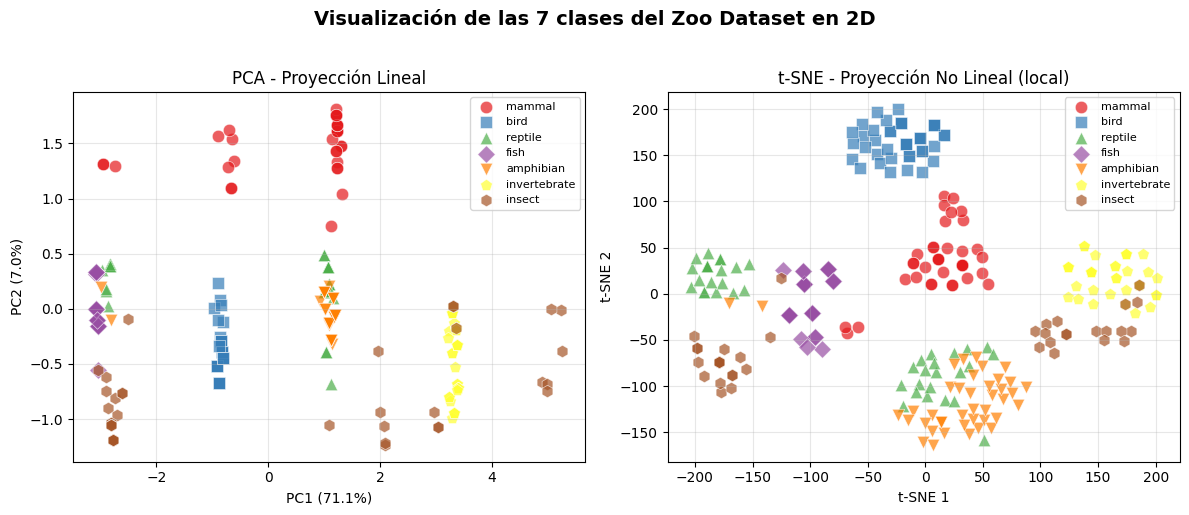


✓ Figura t-SNE guardada como 'tsne_dataset.pdf' y 'tsne_dataset.png'


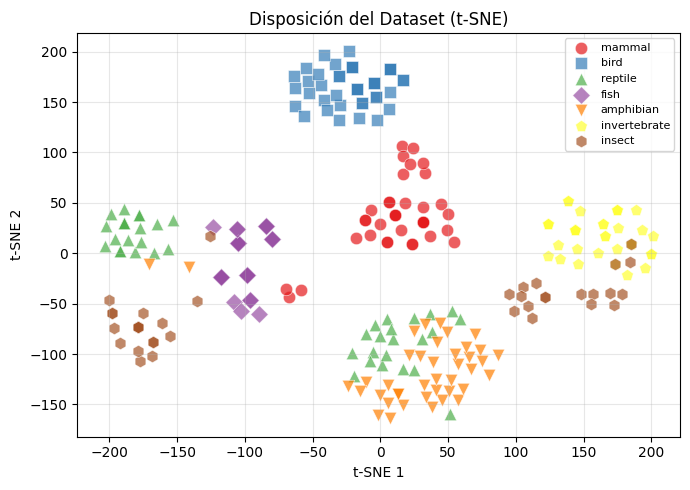


✓ Visualización de embeddings completada


In [54]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("=" * 80)
print("VISUALIZACIÓN DE EMBEDDINGS 2D")
print("=" * 80)

# Colores para las clases (7 clases)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
markers = ['o', 's', '^', 'D', 'v', 'p', 'h']

# Crear figura con subplots (solo PCA y t-SNE)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. PCA
print("\n1. Calculando PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
print(f"   Varianza explicada: {pca.explained_variance_ratio_[0]:.2%} + {pca.explained_variance_ratio_[1]:.2%} = {sum(pca.explained_variance_ratio_):.2%}")

ax = axes[0]
for i, (class_name, color, marker) in enumerate(zip(class_names, colors, markers)):
    mask = y == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, marker=marker, 
               label=class_name, alpha=0.7, edgecolors='white', linewidth=0.5, s=80)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA - Proyección Lineal')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

# 2. t-SNE
print("\n2. Calculando t-SNE (puede tardar unos segundos)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1), 
            n_iter=1000, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)

ax = axes[1]
for i, (class_name, color, marker) in enumerate(zip(class_names, colors, markers)):
    mask = y == i
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, marker=marker,
               label=class_name, alpha=0.7, edgecolors='white', linewidth=0.5, s=80)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE - Proyección No Lineal (local)')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

plt.suptitle('Visualización de las 7 clases del Zoo Dataset en 2D', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Guardar SOLO la figura de t-SNE para la memoria LaTeX
fig_tsne, ax_tsne = plt.subplots(figsize=(7, 5))
for i, (class_name, color, marker) in enumerate(zip(class_names, colors, markers)):
    mask = y == i
    ax_tsne.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, marker=marker,
                    label=class_name, alpha=0.7, edgecolors='white', linewidth=0.5, s=80)
ax_tsne.set_xlabel('t-SNE 1')
ax_tsne.set_ylabel('t-SNE 2')
ax_tsne.set_title('Disposición del Dataset (t-SNE)')
ax_tsne.legend(loc='best', fontsize=8)
ax_tsne.grid(True, alpha=0.3)
plt.tight_layout()

fig_tsne.savefig('tsne_dataset.pdf', format='pdf', dpi=300, bbox_inches='tight')
fig_tsne.savefig('tsne_dataset.png', format='png', dpi=300, bbox_inches='tight')
print("\n✓ Figura t-SNE guardada como 'tsne_dataset.pdf' y 'tsne_dataset.png'")
plt.show()

print("\n✓ Visualización de embeddings completada")

ANÁLISIS DE SOLAPAMIENTO ENTRE CLASES

Matriz de solapamiento (basada en k=5 vecinos en t-SNE):
(Cada celda muestra la proporción de vecinos de cada clase)
--------------------------------------------------------------------------------


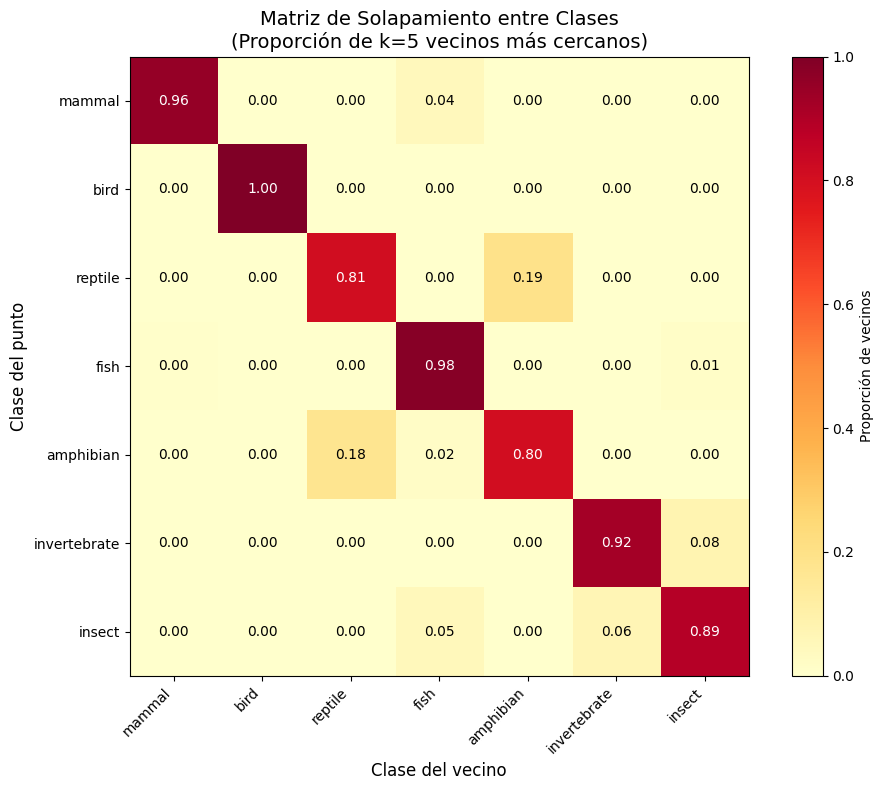


INTERPRETACIÓN DEL SOLAPAMIENTO:

• Clases bien separadas (>80% vecinos de misma clase):
  mammal, bird, reptile, fish, amphibian, invertebrate, insect

• Pares de clases con alto solapamiento (>20% vecinos cruzados):
  No hay pares con alto solapamiento

✓ Análisis de solapamiento completado


In [55]:
# Análisis detallado de solapamiento entre clases
print("=" * 80)
print("ANÁLISIS DE SOLAPAMIENTO ENTRE CLASES")
print("=" * 80)

from sklearn.neighbors import NearestNeighbors
from itertools import combinations

def analyze_class_overlap(X_embedded, y, class_names, k=5):
    """Analiza el solapamiento entre clases basándose en vecinos más cercanos"""
    n_classes = len(class_names)
    overlap_matrix = np.zeros((n_classes, n_classes))
    
    # Para cada punto, encontrar sus k vecinos más cercanos
    nn = NearestNeighbors(n_neighbors=k+1)  # +1 porque incluye el propio punto
    nn.fit(X_embedded)
    distances, indices = nn.kneighbors(X_embedded)
    
    # Calcular la proporción de vecinos de cada clase para cada punto
    for i in range(len(X_embedded)):
        true_class = y[i]
        neighbor_indices = indices[i, 1:]  # Excluir el propio punto
        neighbor_classes = y[neighbor_indices]
        
        # Contar vecinos por clase
        for nc in neighbor_classes:
            overlap_matrix[true_class, nc] += 1
    
    # Normalizar por el número de puntos de cada clase
    for i in range(n_classes):
        class_count = np.sum(y == i)
        if class_count > 0:
            overlap_matrix[i, :] /= (class_count * k)
    
    return overlap_matrix

# Calcular matriz de solapamiento usando t-SNE embedding
print("\nMatriz de solapamiento (basada en k=5 vecinos en t-SNE):")
print("(Cada celda muestra la proporción de vecinos de cada clase)")
print("-" * 80)

overlap = analyze_class_overlap(X_tsne, y, class_names, k=5)

# Crear heatmap de solapamiento
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(overlap, cmap='YlOrRd', vmin=0, vmax=1)

# Añadir etiquetas
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

# Añadir valores en las celdas
for i in range(len(class_names)):
    for j in range(len(class_names)):
        color = 'white' if overlap[i, j] > 0.5 else 'black'
        ax.text(j, i, f'{overlap[i, j]:.2f}', ha='center', va='center', color=color, fontsize=10)

ax.set_xlabel('Clase del vecino', fontsize=12)
ax.set_ylabel('Clase del punto', fontsize=12)
ax.set_title('Matriz de Solapamiento entre Clases\n(Proporción de k=5 vecinos más cercanos)', fontsize=14)
plt.colorbar(im, ax=ax, label='Proporción de vecinos')
plt.tight_layout()
plt.show()

# Análisis textual
print("\n" + "=" * 80)
print("INTERPRETACIÓN DEL SOLAPAMIENTO:")
print("=" * 80)

# Identificar clases bien separadas (diagonal alta, fuera de diagonal baja)
print("\n• Clases bien separadas (>80% vecinos de misma clase):")
well_separated = [class_names[i] for i in range(len(class_names)) if overlap[i, i] > 0.8]
if well_separated:
    print(f"  {', '.join(well_separated)}")
else:
    print("  Ninguna clase está claramente separada")

# Identificar pares de clases con alto solapamiento
print("\n• Pares de clases con alto solapamiento (>20% vecinos cruzados):")
high_overlap_pairs = []
for i, j in combinations(range(len(class_names)), 2):
    cross_overlap = (overlap[i, j] + overlap[j, i]) / 2
    if cross_overlap > 0.2:
        high_overlap_pairs.append((class_names[i], class_names[j], cross_overlap))

if high_overlap_pairs:
    for c1, c2, ov in sorted(high_overlap_pairs, key=lambda x: x[2], reverse=True):
        print(f"  {c1} ↔ {c2}: {ov:.1%}")
else:
    print("  No hay pares con alto solapamiento")

print("\n✓ Análisis de solapamiento completado")

ANÁLISIS DE CARACTERÍSTICAS DISCRIMINATIVAS

Top 5 características más influyentes en PC1:
  1. F13: 0.973 ↑
  2. F1: 0.107 ↑
  3. F14: -0.094 ↓
  4. F10: 0.093 ↑
  5. F12: -0.086 ↓


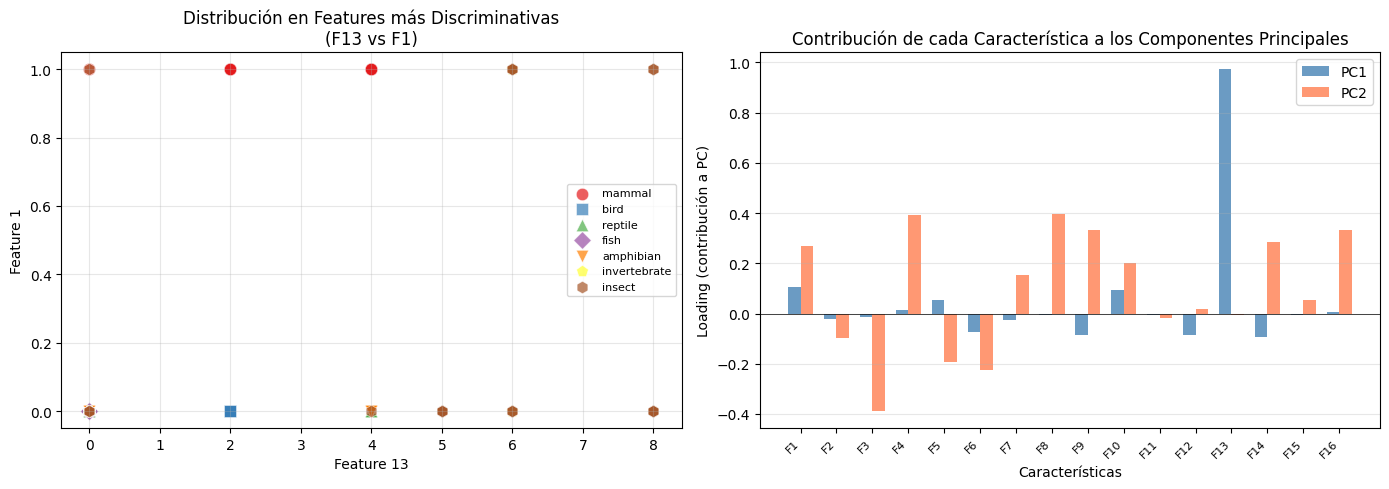


✓ Las características F13 y F1 son las más discriminativas según PCA


In [56]:
# Visualización de la distribución por características más importantes
print("=" * 80)
print("ANÁLISIS DE CARACTERÍSTICAS DISCRIMINATIVAS")
print("=" * 80)

# Usar loadings de PCA para identificar características más importantes
pca_full = PCA(n_components=min(X.shape[1], 5), random_state=42)
pca_full.fit(X)

# Obtener las características más importantes para PC1 y PC2
feature_names = [f'F{i}' for i in range(1, 17)]
loadings = pd.DataFrame(
    pca_full.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=feature_names
)

# Ordenar por importancia en PC1
loadings['abs_PC1'] = np.abs(loadings['PC1'])
loadings_sorted = loadings.sort_values('abs_PC1', ascending=False)

print("\nTop 5 características más influyentes en PC1:")
for i, (feat, row) in enumerate(loadings_sorted.head(5).iterrows()):
    direction = "↑" if row['PC1'] > 0 else "↓"
    print(f"  {i+1}. {feat}: {row['PC1']:.3f} {direction}")

# Visualización de dispersión con las 2 características más importantes
top_features = loadings_sorted.head(2).index.tolist()
f1_idx = int(top_features[0][1:]) - 1
f2_idx = int(top_features[1][1:]) - 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter de las 2 features más discriminativas
ax = axes[0]
for i, (class_name, color, marker) in enumerate(zip(class_names, colors, markers)):
    mask = y == i
    ax.scatter(X.iloc[mask, f1_idx], X.iloc[mask, f2_idx], c=color, marker=marker,
               label=class_name, alpha=0.7, edgecolors='white', linewidth=0.5, s=80)
ax.set_xlabel(f'Feature {f1_idx+1}')
ax.set_ylabel(f'Feature {f2_idx+1}')
ax.set_title(f'Distribución en Features más Discriminativas\n({top_features[0]} vs {top_features[1]})')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Loadings de PCA
ax = axes[1]
x_pos = np.arange(len(feature_names))
width = 0.35
bars1 = ax.bar(x_pos - width/2, loadings['PC1'].values, width, label='PC1', color='steelblue', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, loadings['PC2'].values, width, label='PC2', color='coral', alpha=0.8)
ax.set_xlabel('Características')
ax.set_ylabel('Loading (contribución a PC)')
ax.set_title('Contribución de cada Característica a los Componentes Principales')
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

print(f"\n✓ Las características {top_features[0]} y {top_features[1]} son las más discriminativas según PCA")